<span style="font-size:5em;">Titanic Dataset</span>

**Michał M.**

# Introduction
This is my first kernel at Kaggle. I choosed the Titanic competition, it is well known, I just wanted to train my python skills, as I am advenced R user, but have minor experience with python.

This script follows three main parts:

* Feture analysis
* Feature engineering
* Modeling

In [1]:
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

sns.set_style('whitegrid')

# Data load and initial checks

## Data import

In [2]:
# load data
train = pd.read_csv('./01 Data/train.csv')
test  = pd.read_csv('./01 Data/test.csv')

# preview
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Joining train and test set

In [3]:
# join train and test datasets in order to obtain the same number of features

train_len = len(train)
full_dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## NULL and missing values

In [4]:
# fill empty and Nan's values with NaN
dataset = full_dataset.fillna(np.nan)

# null values
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

In [5]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [6]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There is a lot missing values in the **cabin** column (almost 80%), what probably will make it hard to use.

# Variables exploration

## Numerical variables

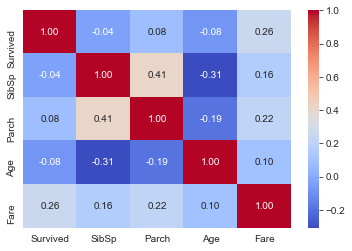

In [7]:
# correlation matrix
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')

### SibSp

*number of siblings/spouses aboard the Titanic*

The dataset defines family relations in this way:
 * Sibling = brother, sister, stepbrother, stepsister;
 * Spouse = husband, wife (mistresses and fiancés were ignored).

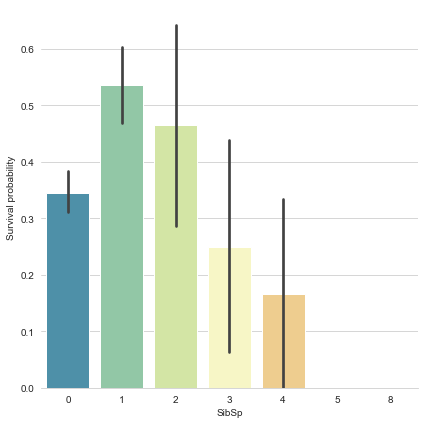

In [8]:
# SibSp vs Survived
p = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Seems that that higher number of siblings/spouses decrease the chance of survival.

### Parch

*number of parents/children aboard the Titanic*

The dataset defines family relations in this way:
 * Parent = mother, father;
 * Child = daughter, son, stepdaughter, stepson.
 
Some children travelled only with a nanny, therefore parch=0 for them.

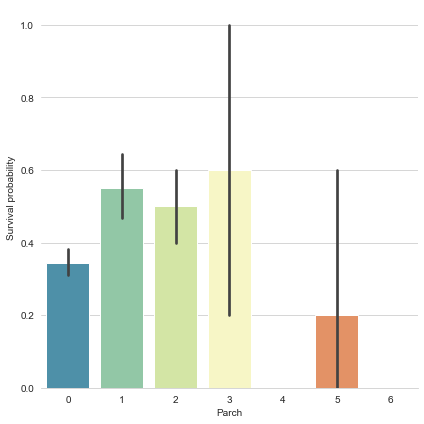

In [9]:
# Parch vs Survived
p = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', height = 6, palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

### Age

*Age in years*

Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

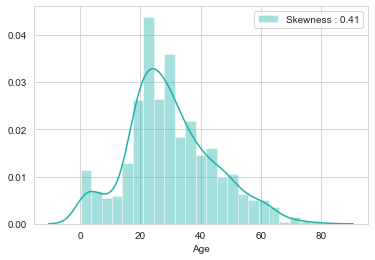

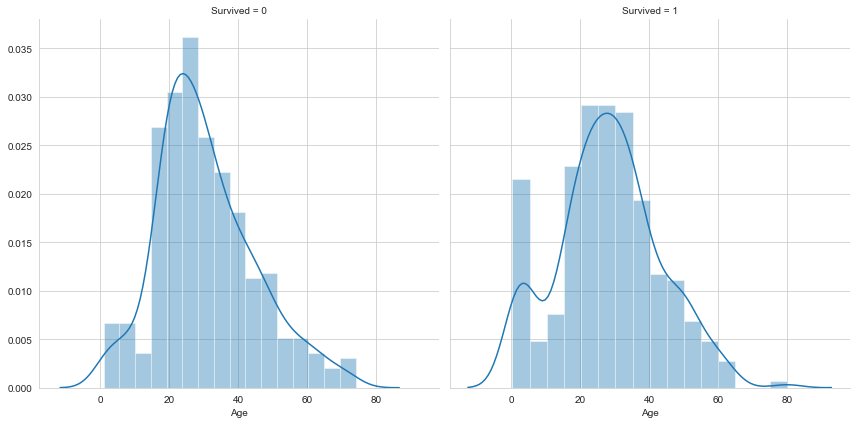

In [10]:
# Age distribution
p = sns.distplot(dataset['Age'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Age'].skew()))
p = p.legend(loc='best')

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Age')

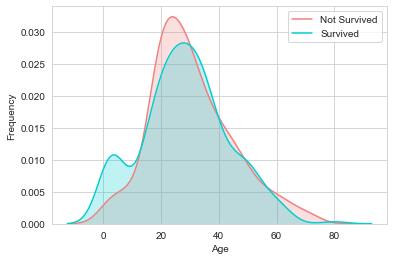

In [11]:
# comparison on single plot
p = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Age')
p.set_ylabel('Frequency')
p = p.legend(['Not Survived','Survived'])

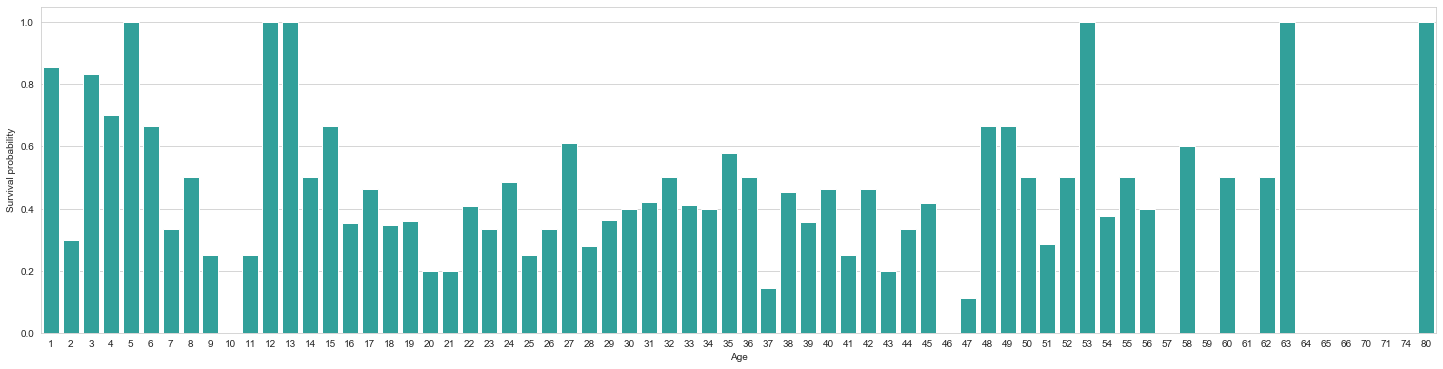

In [12]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[['Age', 'Survived']].apply(np.ceil).groupby(['Age'], as_index=False).mean()
avg_survival_by_age[['Age']] = avg_survival_by_age[['Age']].astype(int)
p = sns.barplot(x='Age', y='Survived', data=avg_survival_by_age, color='LightSeaGreen')
p = p.set_ylabel('Survival probability')

### Fare

*Passenger fare*

Remeber, there was one observation with `Null` value in the **Fare** column.

In [13]:
dataset['Fare'].isnull().sum()

1

We will fill it with median value of the column.

In [14]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

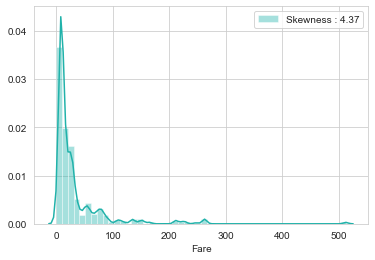

In [15]:
# Fare distribution over whole data
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

Fare distribution is very skewed, we tried to *unskew* it usin logarithm function

In [16]:
# log function on Fare to reduce skewness
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
train['Fare'] = train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

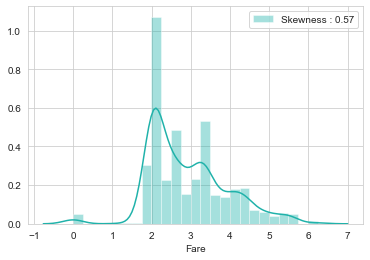

In [17]:
p = sns.distplot(dataset['Fare'], color='LightSeaGreen', label='Skewness : %.2f'%(dataset['Fare'].skew()))
p = p.legend(loc='best')

After tranformation it looks much better, no other modifications are curently needed. Let plot *Fare* variable and its distribution wrt survival.

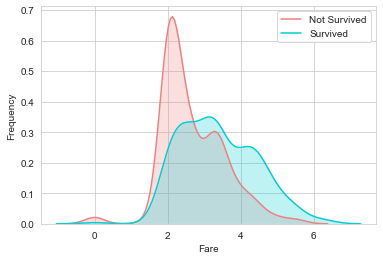

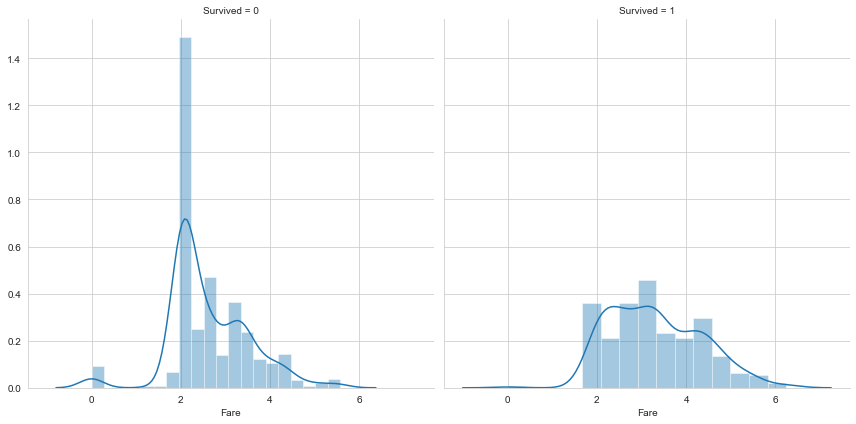

In [18]:
# comparison on single plot
p = sns.kdeplot(train['Fare'][(train['Survived'] == 0) & (train['Age'].notnull())], color='lightcoral', shade=True)
p = sns.kdeplot(train['Fare'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=p, color='darkturquoise', shade=True)
p.set_xlabel('Fare')
p.set_ylabel('Frequency')
p = p.legend(['Not Survived','Survived'])

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, 'Fare')

There is slight, visible diffrence beetween distributions.

## Categorical Variables

Now we proceed to categorical variables and their distribution with relation to variable *Survived*

### Sex

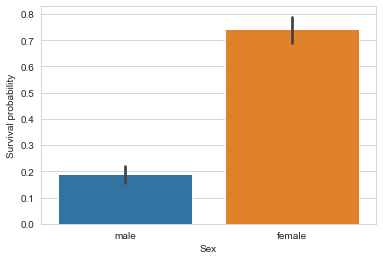

In [19]:
p = sns.barplot(x='Sex' ,y='Survived', data=train)
p = p.set_ylabel('Survival probability')

It is visible, that **sex** play import role in survival of the underlying passenger. 

In [20]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


#### Pclass

*Ticket class*

A proxy for socio-economic status (SES):
 * 1st = Upper
 * 2nd = Middle
 * 3rd = Lower

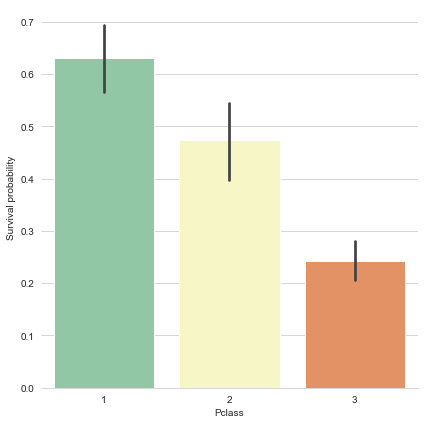

In [21]:
# Pclass vs Survived
p = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

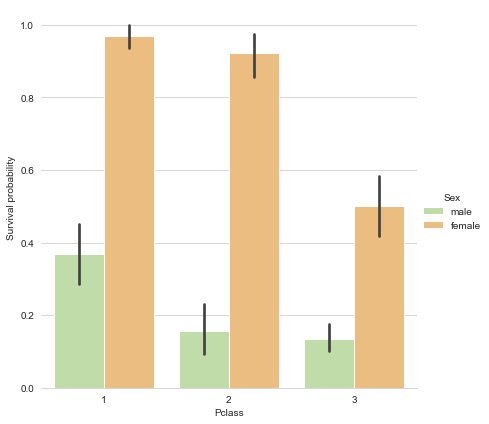

In [22]:
# Pclass vs Survived vs Sex
p = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

### Embarked

*Port of Embarkation*

A port of embarkation coded as:
 * C = Cherbourg;
 * Q = Queenstown;
 * S = Southampton.
 
 
 There we two observations with `Null` value in the **Embarked** column.

In [23]:
dataset['Embarked'].isnull().sum()

2

We filled it with most common value, i.e. 'S'.

In [24]:
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode())

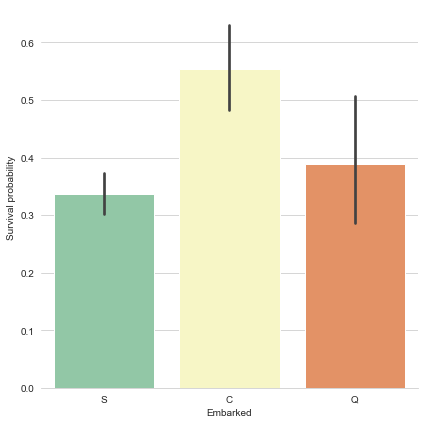

In [25]:
# Embarked vs Survived
p = sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', height=6 , palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

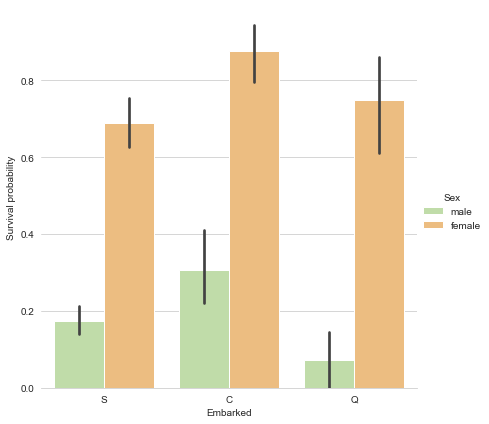

In [26]:
# Embarked vs Survived vs Sex
p = sns.catplot(x='Embarked', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r')
p.despine(left=True)
p = p.set_ylabels('Survival probability')

It seems that passenger coming from Cherbourg have more chance to survive.

Let's check proportion of classes among all three ports.

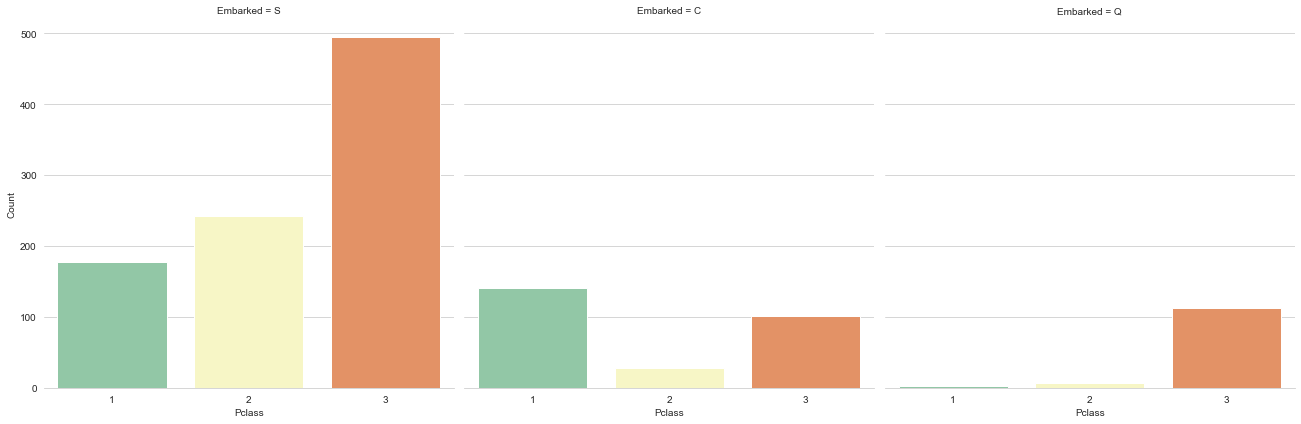

In [27]:
# Pclass vs Embarked 
g = sns.catplot('Pclass', col='Embarked', data=dataset, height=6, kind='count', palette='Spectral_r')
g.despine(left=True)
g = g.set_ylabels('Count')

We can conclude that the third class is the most frequent for passenger coming from Southampton and Queenstown, whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

We can't explain why first class has an higher survival rate. Probably first class passengers were prioritised during the evacuation due to their influence.

# Missing Values

## Age

Variable **Age** contains 256 missing values which should be somehow filled in order to preserve usability of **Age** variable. It is import as during initial data exploration we found that kids have diffrent survival probability than adults and elder people. 

Let's look at the variables most correlated with the **Age** and its distribution among them.  

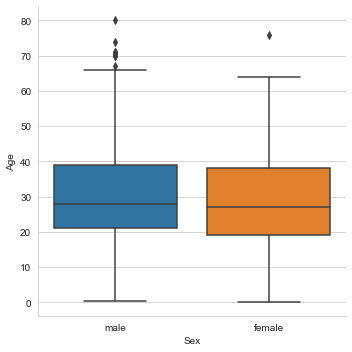

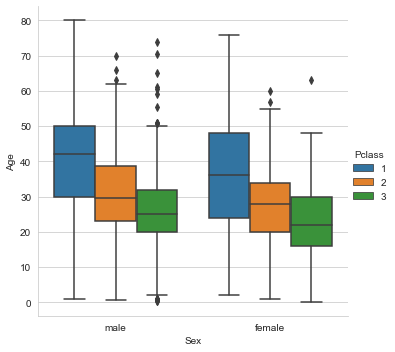

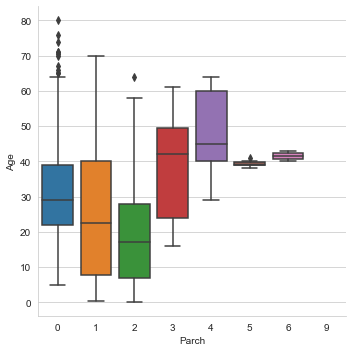

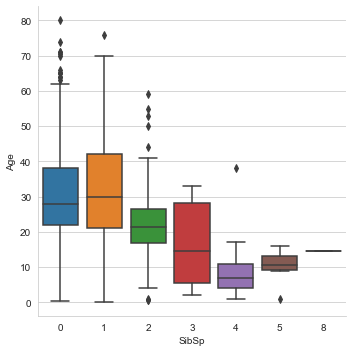

In [28]:
#  Age vs Sex, Parch, Pclass and SibSP (whole dataset)
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

In [29]:
# fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# warning is showed

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\Users\Michal\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Feature engineering

## Family size

According to the Kaggle data dictionary, both **SibSp** and **Parch** relate to traveling with family. We can combine both to introduce variable **Family size**, deonted **FamS**. We suppose that large families might be hard to be rescued during disaster. 

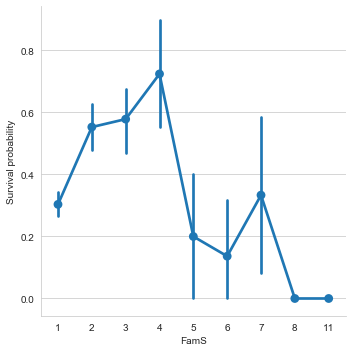

In [30]:
# family size descriptor from SibSp and Parch
dataset['FamS'] = dataset['SibSp'] + dataset['Parch'] + 1
train['FamS'] = train['SibSp'] + train['Parch'] + 1

p = sns.catplot(x='FamS', y='Survived', data = train, kind = 'point')
p = p.set_ylabels('Survival probability')

We add additional categorical variable to aggregate family size.

In [31]:
# Create new feature of family size
def family_size(peers):
    size = 'Large'
    if peers == 1:
        size = 'Single'
    elif peers <= 3:
        size = 'Small'
    elif peers == 4:
        size = 'Medium'
    return size

dataset['FamSCat'] = dataset['FamS'].map(family_size)
train['FamSCat'] = train['FamS'].map(family_size)

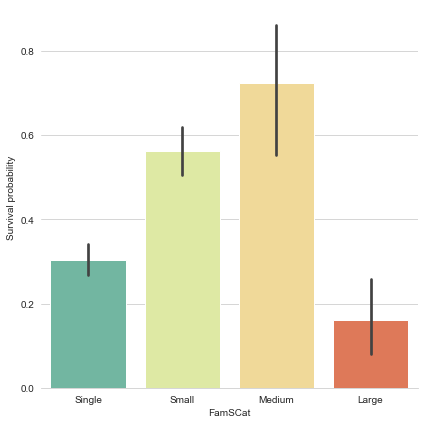

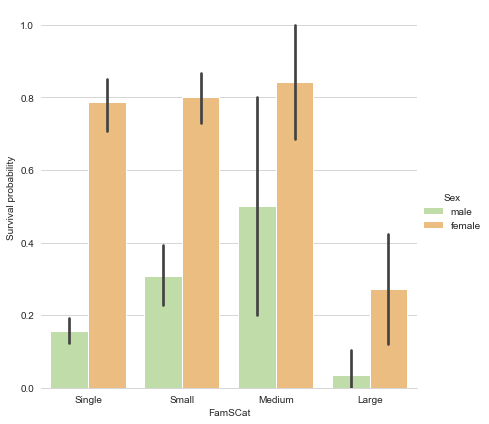

In [32]:
# FamSCat vs Survived
p = sns.catplot(x='FamSCat', y='Survived', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

# FamSCat vs Survived vs Sex
p = sns.catplot(x='FamSCat', y='Survived', hue='Sex', data=train, height=6, kind='bar', palette='Spectral_r', order=['Single', 'Small', 'Medium', 'Large'])
p.despine(left=True)
p = p.set_ylabels('Survival probability')

Obtained variable migh be usefull during forecasting as there is visible diffrence among the groups.

## Title

We try to extract title from the **Name** colum.

In [33]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [34]:
# Title from Name
dataset['Title'] = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

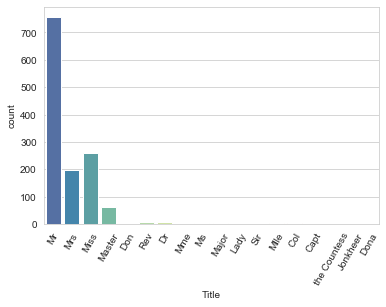

In [35]:
p = sns.countplot(x='Title', data=dataset, palette='Spectral_r')
p = plt.setp(p.get_xticklabels(), rotation=60) 

In [36]:
# convert to categorical values 
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace(['Miss', 'Ms', 'Mme', 'Mlle', 'Mrs'], 'Ladys_title')
dataset['Title'].head()

0             Mr
1    Ladys_title
2    Ladys_title
3    Ladys_title
4             Mr
Name: Title, dtype: object

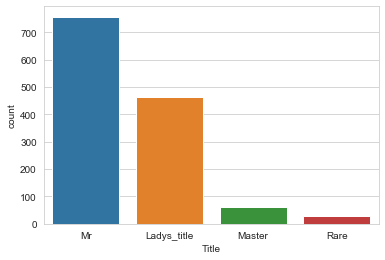

In [37]:
p = sns.countplot(dataset['Title'])

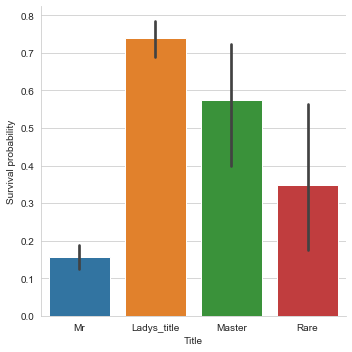

In [38]:
p = sns.catplot(x='Title', y='Survived', data=dataset, kind='bar')
p = p.set_ylabels('Survival probability')

# Modelling 

## Dummy variables/train set preparation

Before start of modelling we create dummy variables for all categorical variables we had in the dataset.

In [39]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamS', 'FamSCat',
       'Title'],
      dtype='object')

In [40]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset_final = pd.get_dummies(dataset.drop(labels=['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=False), prefix=['Pclass', 'Sex','Embarked', 'FamSCat', 'Title'])
dataset_final.head()

,Survived,Age,SibSp,Parch,FamS,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Embarked_Q,Embarked_S,FamSCat_Large,FamSCat_Medium,FamSCat_Single,FamSCat_Small,Title_Ladys_title,Title_Master,Title_Mr,Title_Rare
0,0.0,22.0,1,0,2,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,1.0,38.0,1,0,2,1,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
2,1.0,26.0,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,1,0,0,0
3,1.0,35.0,1,0,2,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
4,0.0,35.0,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [41]:
train_final = dataset_final.loc[:train.shape[0]-1, ]
test_final = dataset_final.loc[train.shape[0]:, ]

In [42]:
(test_final.shape[0] == test.shape[0]) & (train_final.shape[0] == train.shape[0])

True

In [43]:
# ignore warning
test_final.drop(labels=['Survived'], axis=1, inplace=True) 

C:\Users\Michal\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [44]:
train_final['Survived'] = train_final['Survived'].astype(int)

Y_train = train_final['Survived']
X_train = train_final.drop(labels = ['Survived'], axis = 1)

C:\Users\Michal\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Fast modelling

We do build couple of simple models and compare them using CV. That should reveal which models are worth being analised further. 

In [234]:
# CV
kfold = StratifiedKFold(n_splits=50)

In [200]:
# aggregated testing
random_state = 2137

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [201]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'kNN', 'LogisticRegression', 'LDA'], 'CrossValMeans':cv_means, 'CrossValErrors':cv_std})

In [202]:
cv_res.sort_values(by=['CrossValMeans'], ascending=False, inplace=True)
cv_res.reset_index(drop=True, inplace=True)
cv_res

,Algorithm,CrossValMeans,CrossValErrors
0,LDA,0.833137,0.076270
1,LogisticRegression,0.827582,0.084145
2,GradientBoosting,0.826405,0.086224
3,MultipleLayerPerceptron,0.824052,0.080250
4,kNN,0.794902,0.077906
5,RandomForest,0.784706,0.090661
6,DecisionTree,0.783464,0.087557
7,AdaBoost,0.782484,0.086022
8,ExtraTrees,0.779150,0.095068
9,SVC,0.776993,0.079184


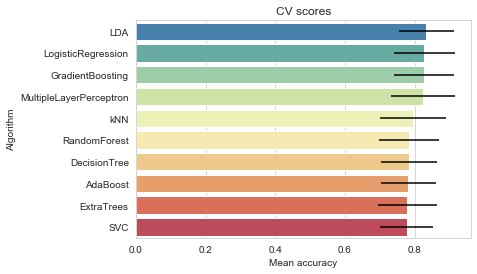

In [203]:
p = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Spectral_r',orient='h', **{'xerr':cv_std})
p.set_xlabel('Mean accuracy')
p = p.set_title('CV scores')

We choose the LDA, Logistic regression, MLP, and the Gradient boosting classifiers for the further tunning and ensamble modeling modeling. 
We also choose SVM just to check whether we are be able to tunning it well.

## Hyperparameter tunning

We execute grid search to find best hyperparameters for chosen algorithms. LDA and logistic regression is also optimized.

###  Logistic regression

In [189]:
# LDA classifier tunning
pipe_LR_Classifier = Pipeline([('scaler',  StandardScaler()),
                               ('logistic_regressor', LogisticRegression())])

lrc_param_grid = {'logistic_regressor__penalty': ['elasticnet'],
                  'logistic_regressor__C': [0.01],                # 0.01, 0.05, 0.1, 0.5, 1
                  'logistic_regressor__class_weight': [None],    # None, 'balanced'
                  'logistic_regressor__solver': ['saga'],
                  'logistic_regressor__l1_ratio': [0]          # 0, 0.1, 0.4, 0.5, 0.6, 0.9, 1
                 }

gs_lr = GridSearchCV(pipe_LR_Classifier, param_grid=lrc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_lr.fit(X_train, Y_train)

lr_best = gs_lr.best_estimator_

# best score
gs_lr.best_score_

Fitting 100 folds for each of 1 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


0.8331944444444445

In [190]:
lr_best

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic_regressor',
                 LogisticRegression(C=0.01, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### MLP

In [164]:
# LDA classifier tunning
pipe_NN_Classifier = Pipeline([('scaler',  StandardScaler()),
                               ('nn', MLPClassifier())])

nn_param_grid = {'nn__solver': ['lbfgs'],
                 'nn__hidden_layer_sizes': [(50, 50)]
                }

gs_nn = GridSearchCV(pipe_NN_Classifier, param_grid=nn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_nn.fit(X_train, Y_train)

nn_best = gs_nn.best_estimator_

# best score
gs_nn.best_score_

Fitting 25 folds for each of 4 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.8s finished
C:\Users\Michal\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8204126984126984

In [165]:
nn_best

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('nn',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

### Gradient boosting

In [213]:
# gradient boosting tunning
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators' : [400],    # 100, 200, 300, 350, 400, 450, 600, 900
                 'learning_rate': [0.1],    # 0.001, 0.05, 0.1, 0.2
                 'max_depth': [19],         # 5, 8, 10, 12, 15, 18, 19, 20, 21
                 'min_samples_leaf': [200], # 150, 200, 250, 300, 400
                 'max_features': [0.85]      #  0.25, 0.5, 0,75, 0.8, 0.85, 0.9
                }

gs_gb = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_gb.fit(X_train, Y_train)

gb_best = gs_gb.best_estimator_

# best score
gs_gb.best_score_

Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.9s finished


0.8305228758169935

In [214]:
gb_best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=19,
                           max_features=0.85, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=200, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### kNN

In [248]:
# kNN classifier tunning
pipe_kNN_Classifier = Pipeline([('scaler',  StandardScaler()),
                                ('kNN', KNeighborsClassifier())])

knn_param_grid = {'kNN__n_neighbors': [21],   # list(range(1, 51))
                  'kNN__weights': ['uniform'], # 'uniform', 'distance'
                  'kNN__p': [1]                # 1, 2, 3
                 }

gs_knn = GridSearchCV(pipe_kNN_Classifier, param_grid=knn_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_knn.fit(X_train, Y_train)

knn_best = gs_knn.best_estimator_

# best score
gs_knn.best_score_

Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


0.8318954248366013

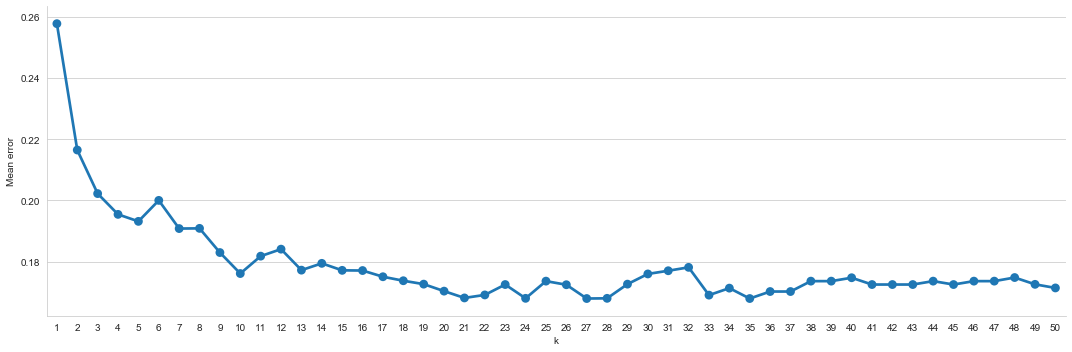

In [242]:
knn_cv_results = pd.DataFrame(gs_knn.cv_results_)
knn_cv_results['Mean error'] = 1 - knn_cv_results['mean_test_score']


p = sns.catplot(x='param_kNN__n_neighbors', y='Mean error', data=knn_cv_results, kind='point', aspect=3)
p = p.set_xlabels('k')

In [249]:
knn_best

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=21, p=1,
                                      weights='uniform'))],
         verbose=False)

### Random forest

In [52]:
# RF tunning 
RFC = RandomForestClassifier()

# search grid for optimal parameters
rf_param_grid = {'max_depth': [None],       # None, 5, 10
                 'max_features': [2],       # 1, 2, 3
                 'min_samples_split': [10], # 5, 10, 15 
                 'min_samples_leaf': [10],  # 5, 10, 15 
                 'bootstrap': [False],
                 'n_estimators' :[100],     # 100, 300, 600
                 'criterion': ['gini']
                }


gs_rf = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=1)

gs_rf.fit(X_train, Y_train)

rf_best = gs_rf.best_estimator_

# best score
gs_rf.best_score_

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


0.8304545454545454

In [53]:
rf_best

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### SVM  

In [56]:
# SVM classifier tunning
pipe_SVM_Classifier = Pipeline([('scaler',  StandardScaler()),
                                ('SVC', SVC(probability=True))])

svc_param_grid = {'SVC__C': [250],             # 1, 25, 50, 75, 100, 125, 250, 500, 100
                  'SVC__kernel': ['rbf'], 
                  'SVC__gamma': [0.001],       # 0.0005, 0.001, 0.005, 0.01, 'scale', 'auto'
                  'SVC__class_weight': [None], # None, 'balanced'
                 }

gs_svm = GridSearchCV(pipe_SVM_Classifier, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gs_svm.fit(X_train,Y_train)

svm_best = gs_svm.best_estimator_

# best score
gs_svm.best_score_

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished


0.834949494949495

In [57]:
svm_best

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=250, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

## Learning Curve

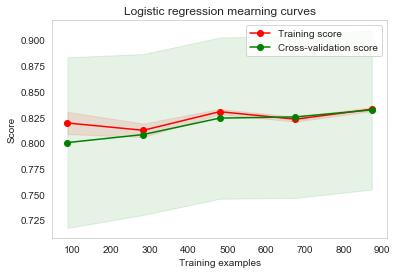

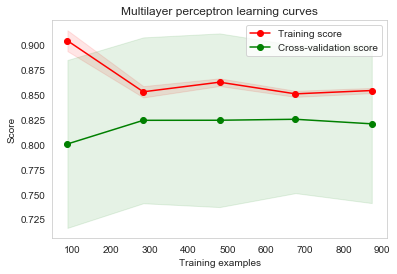

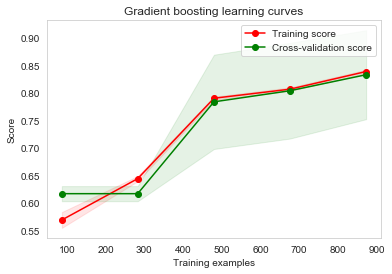

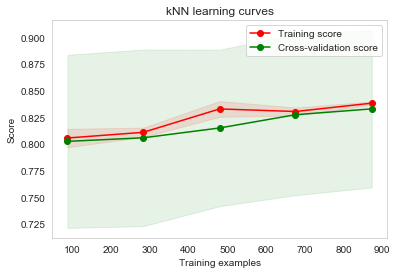

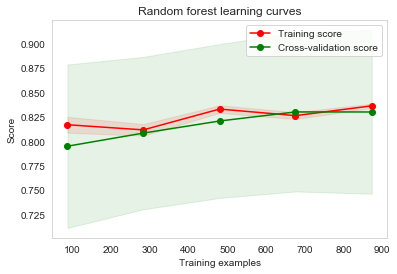

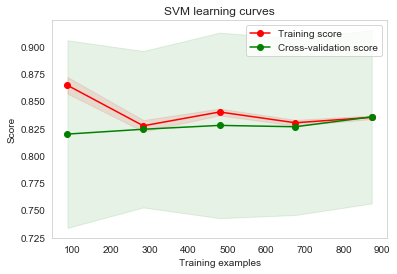

In [250]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

p = plot_learning_curve(lr_best,"Logistic regression mearning curves",X_train,Y_train,cv=kfold)
p = plot_learning_curve(nn_best,"Multilayer perceptron learning curves",X_train,Y_train,cv=kfold)
p = plot_learning_curve(gb_best,"Gradient boosting learning curves",X_train,Y_train,cv=kfold)
p = plot_learning_curve(knn_best,"kNN learning curves",X_train,Y_train,cv=kfold)
p = plot_learning_curve(rf_best,"Random forest learning curves",X_train,Y_train,cv=kfold)
p = plot_learning_curve(svm_best,"SVM learning curves",X_train,Y_train,cv=kfold)

##  Feature importance

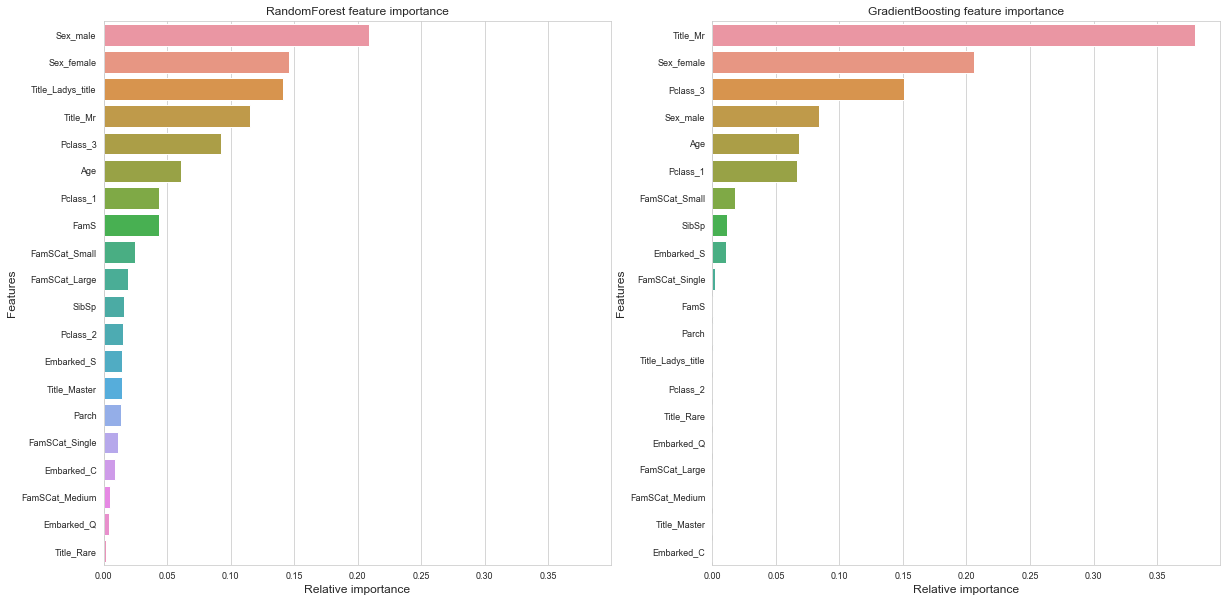

In [256]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex="all", figsize=(20,10))

names_classifiers = [("RandomForest",rf_best),("GradientBoosting",gb_best)]

nclassifier = 0

for col in range(2):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    p = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[col])
    p.set_xlabel("Relative importance",fontsize=12)
    p.set_ylabel("Features",fontsize=12)
    p.tick_params(labelsize=9)
    p.set_title(name + " feature importance")
    nclassifier += 1

## Prediction diffrences among models

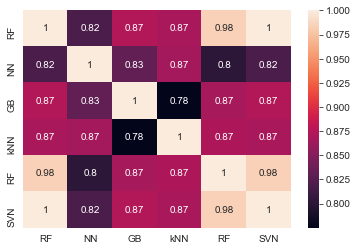

In [258]:
test_Survived_lr = pd.Series(lr_best.predict(test_final), name="RF")
test_Survived_nn = pd.Series(nn_best.predict(test_final), name="NN")
test_Survived_gb = pd.Series(gb_best.predict(test_final), name="GB")
test_Survived_knn = pd.Series(knn_best.predict(test_final), name="kNN")
test_Survived_rf = pd.Series(rf_best.predict(test_final), name="RF")
test_Survived_svn = pd.Series(svm_best.predict(test_final), name="SVN")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_lr, test_Survived_nn, test_Survived_gb, test_Survived_knn, test_Survived_rf, test_Survived_svn], axis=1)


p = sns.heatmap(ensemble_results.corr(),annot=True)

## Ensamble modeling

In [259]:
voting = VotingClassifier(estimators=[('lr', lr_best), 
                                      ('nn', nn_best), 
                                      ('gb', gb_best), 
                                      ('knn', knn_best), 
                                      ('rf', rf_best), 
                                      ('svm', svm_best)], voting='soft', n_jobs=-1)

voting = voting.fit(X_train, Y_train)

## Final prediction

In [261]:
test_Survived = pd.Series(voting.predict(test_final), name="Survived")

results = pd.concat([test["PassengerId"], test_Survived], axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)